# Ensemble MobilenetV2 and VGG19 Model

In [1]:
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import clear_output
import gc
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import pandas as pd
import signal

2024-12-13 15:01:27.907357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734102088.886258   18860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734102089.273469   18860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 15:01:31.355778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
mblnet = tf.keras.models.load_model("models/keras_mobilenetv2/ib25_mobilenetv2.keras")
vggmdl = tf.keras.models.load_model("models/keras_vgg19/ib25_vgg19.keras")
class_name = joblib.load("models/keras_vgg19/class_name.pkl")

I0000 00:00:1734102129.222706   18860 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/sidthechillguy/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Our models already have a resize and normalize layer built in

Ask both models to predict the image class

In [3]:
# add a counter which will delete the models and reload them to clean up the memory cache
counter = 0

def PredictFunction(inimg):
    
    global counter
    global mblnet
    global vggmdl
    
    if counter>20:
        counter = 0
        del mblnet
        del vggmdl
        
        mblnet = tf.keras.models.load_model("models/keras_mobilenetv2/ib25_mobilenetv2.keras")
        vggmdl = tf.keras.models.load_model("models/keras_vgg19/ib25_vgg19.keras")
    else:
        counter += 1
    
    tf.keras.backend.clear_session()
    gc.collect
    
    try:
        img = tf.keras.preprocessing.image.img_to_array(inimg)
        img = np.expand_dims(img, axis=0)
    except:
        img = np.expand_dims(inimg, axis=0)

    predmbnet = mblnet.predict(img)
    predvgg = vggmdl.predict(img)

    predclassmbnet = np.argmax(predmbnet[0])
    predclassvgg = np.argmax(predvgg[0])

    confmbnet = predmbnet[0][predclassmbnet]
    confvgg = predvgg[0][predclassvgg]
    
    if (predclassmbnet == predclassvgg):
        return class_name[predclassvgg], "VGG19 and MobileNetV2",(confmbnet + confvgg)/2
    else:
        if(confvgg>confmbnet):
            return class_name[predclassvgg], "VGG19", confvgg
        else:
            return class_name[predclassmbnet], "MobileNetV2", confmbnet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


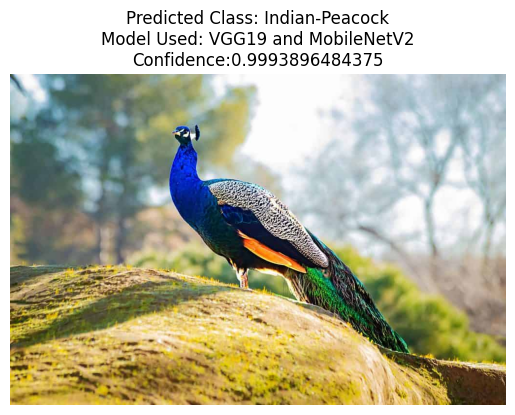

In [5]:
img = Image.open("test_images/indp.jpg")
name, modelused, conf = PredictFunction(img)

plt.title(f"Predicted Class: {name}\nModel Used: {modelused}\nConfidence:{conf}")
plt.axis("off")
plt.imshow(img)
plt.show()

# Run the ensemble on Test Data

In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('Birds_25/valid/',
                                                              shuffle=True,
                                                              image_size=(
                                                                  224, 224),
                                                              batch_size=8,
                                                              seed=42,
                                                              )

Found 7500 files belonging to 25 classes.


Create a timeout process to exit the for loop if it takes more than 4 minutes per single pass of a batch to execute

In [7]:
# Define a custom exception for timeout
class TimeoutException(Exception):
    pass

# Define a handler for the timeout
def timeout_handler(signum, frame):
    raise TimeoutException


# Set the signal handler for the alarm signal
signal.signal(signal.SIGALRM, timeout_handler)

# Function to run with a timeout
def run_with_timeout(inimg, timeout):
    signal.alarm(timeout)  # Set the alarm
    try:
        a, b, c = PredictFunction(inimg)
        return a, b, c

    except TimeoutException:
        print("Function took too long to complete.")
    finally:
        signal.alarm(0)  # Disable the alarm

run the tests

In [8]:
y_true = []
modellist = []
y_pred = []

In [9]:
for image,label in test_ds:
    try:
        for i in range(8):
            name, modelused, conf = run_with_timeout(image[i], 60) # 60 sec or 1 min maximum time
            y_pred.append(name)
            y_true.append(class_name[label[i].numpy()])
            modellist.append(modelused)
            clear_output(wait=True)
    except:
        print("Test method reached the end of testing dataset slices or timed out. Aborted for further runs.")
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step
Function took too long to complete.
Test method reached the end of testing dataset slices or timed out. Aborted for further runs.


In [10]:
bothcnt = 0
vggcnt = 0
mbcnt = 0

In [11]:
for i in modellist:
    if i=="VGG19 and MobileNetV2":
        bothcnt += 1
    elif i == "VGG19":
        vggcnt += 1
    elif i=="MobileNetV2":
        mbcnt += 1

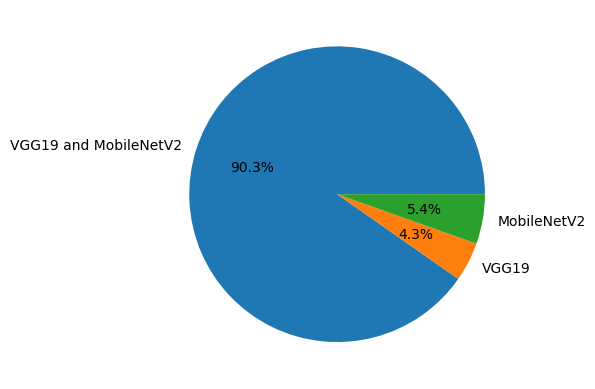

In [12]:
y = np.array([bothcnt, vggcnt, mbcnt])
lab = ["VGG19 and MobileNetV2","VGG19","MobileNetV2"]
plt.pie(y,labels=lab,autopct='%1.1f%%')
plt.show()

Classification metrics and confusion matrix

In [13]:
clsrpt = classification_report(y_true,y_pred,target_names=class_name,output_dict=True)
confmat = confusion_matrix(y_pred, y_true)

<Axes: >

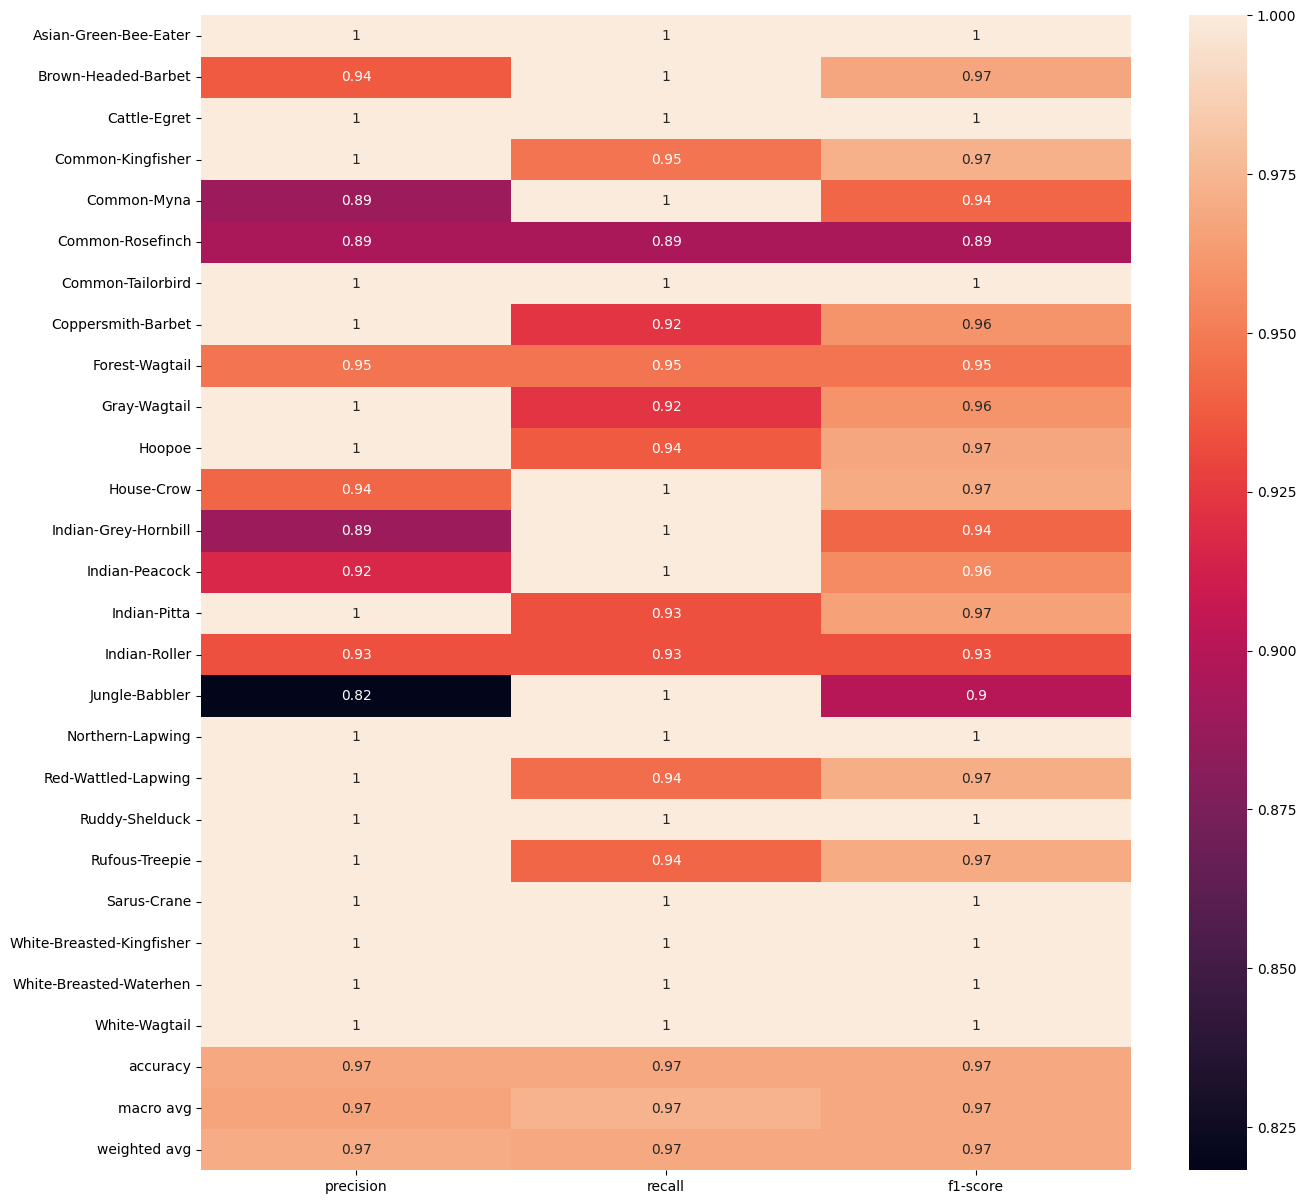

In [14]:
plt.figure(figsize=(15,15))

# we remove support to adjust the 
sns.heatmap(pd.DataFrame(clsrpt).iloc[:-1,:].T, annot=True)

<Axes: >

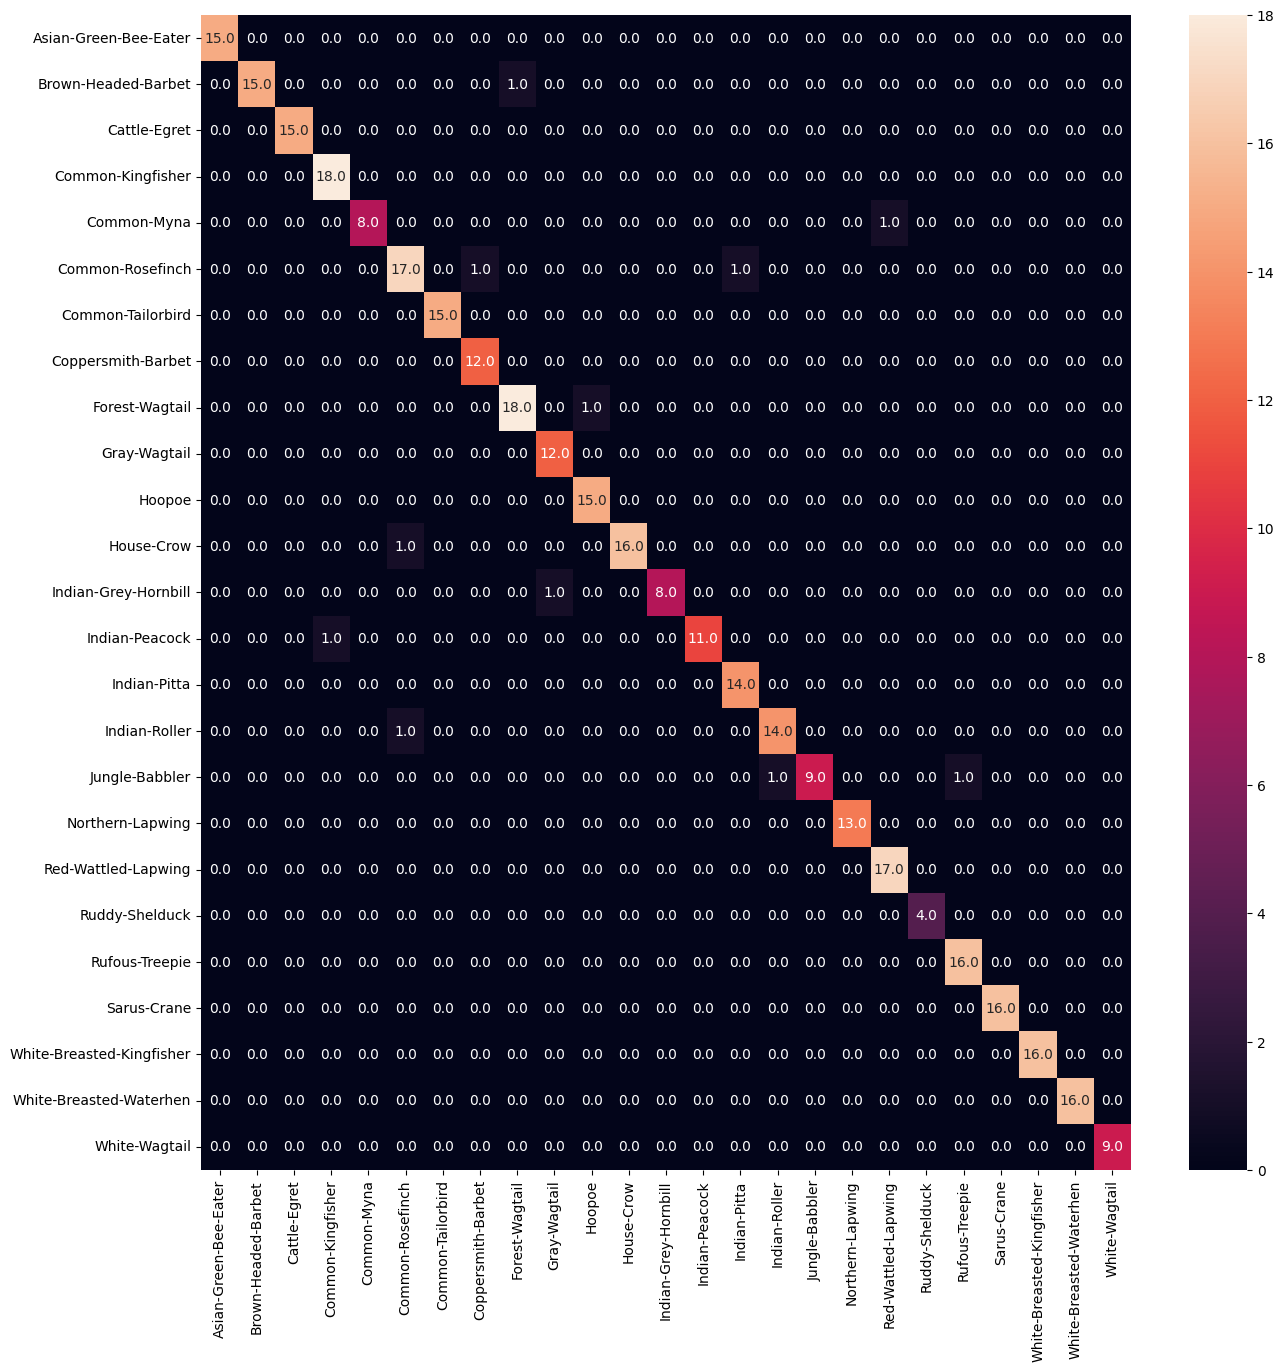

In [15]:
plt.figure(figsize=(15,15))
sns.heatmap(confmat, annot=True, fmt='.1f',xticklabels=class_name, yticklabels=class_name)